## 🔍 INTERPRÉTATION DES RÉSULTATS - Prix réels vs Log-prix

⚠️ **ATTENTION** : Vos modèles prédisent en **log-prix** !  
Pour obtenir le **prix réel**, il faut faire la transformation inverse : `np.expm1(log_prix)`

In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score


import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## SPLIT

In [3]:
df = pd.read_feather("../data_model/houses.feather")
df.head(1)

,buy_price,sq_mt_built,n_rooms,n_bathrooms,neighborhood,has_lift,has_parking,has_pool,has_garden,has_storage_room,is_floor_under,product
0,85000,64.0,2,1.0,135,0.0,0,0,0,0,0.0,appartement


In [4]:
X = df.drop(columns=['buy_price'])
y = df['buy_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape) 

(17163, 11)
(17163,)
(4291, 11)
(4291,)


In [6]:
# Train
X_train.reset_index(drop=True).to_feather("../data_model/X_train.feather")
y_train.reset_index(drop=True).to_frame("buy_price").to_feather("../data_model/y_train.feather")

# Test
X_test.reset_index(drop=True).to_feather("../data_model/X_test.feather")
y_test.reset_index(drop=True).to_frame("buy_price").to_feather("../data_model/y_test.feather")

In [7]:
# df.to_feather(r'data/houses.feather')
X_train = pd.read_feather("../data_model/X_train.feather")
y_train = pd.read_feather("../data_model/y_train.feather")
X_test = pd.read_feather("../data_model/X_test.feather")
y_test = pd.read_feather("../data_model/y_test.feather")

# Convertit y en Series 1d
y_train = y_train.iloc[:,0]
y_test  = y_test.iloc[:,0]

## PREPROCESSING - StandardScaler + Variables catégorielles

Le StandardScaler est **crucial** pour la régression linéaire car :
- Les variables ont des échelles très différentes (surface vs nombre de pièces)
- Sans normalisation, les coefficients sont biaisés vers les variables à grande échelle
- Les algorithmes convergent plus rapidement avec des données normalisées

In [8]:
# ✅ 1) Forcer neighborhood en catégoriel (car il est en int64 mais c'est une catégorie)
X_train["neighborhood"] = X_train["neighborhood"].astype("category")
X_test["neighborhood"]  = X_test["neighborhood"].astype("category")

# ✅ 1.5) Forcer product en catégoriel aussi
X_train["product"] = X_train["product"].astype("category")
X_test["product"]  = X_test["product"].astype("category")

# ✅ 2) Définir explicitement les colonnes
# Neighborhood et product sont catégorielles dans ce dataset
categorical_features = ["neighborhood", "product"]

# Toutes les autres colonnes = numériques (dans ton dataset)
numeric_features = [c for c in X_train.columns if c not in categorical_features]

print(f"Features numériques ({len(numeric_features)}): {numeric_features}")
print(f"Features catégorielles ({len(categorical_features)}): {categorical_features}")

# ✅ 3) Préprocesseur :
# - StandardScaler pour les numériques (utile pour LR/Ridge/Lasso)
# - OneHotEncoder pour neighborhood et product (pas d'ordre artificiel)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False), categorical_features),
    ]
)

# ✅ 4) Fit/transform - GARDER les noms originaux ET créer les versions scalées
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled  = preprocessor.transform(X_test)

print("\nDonnées transformées:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape : {X_test_scaled.shape}")
print(f"Type: {type(X_train_scaled)}")

print(f"\nDonnées originales conservées:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape : {X_test.shape}")

Features numériques (9): ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'has_lift', 'has_parking', 'has_pool', 'has_garden', 'has_storage_room', 'is_floor_under']
Features catégorielles (2): ['neighborhood', 'product']

Données transformées:
X_train_scaled shape: (17163, 141)
X_test_scaled shape : (4291, 141)
Type: <class 'numpy.ndarray'>

Données originales conservées:
X_train shape: (17163, 11)
X_test shape : (4291, 11)


/Users/sulivanmoreau/apartment-hunter/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


In [9]:
X_train.head()

,sq_mt_built,n_rooms,n_bathrooms,neighborhood,has_lift,has_parking,has_pool,has_garden,has_storage_room,is_floor_under,product
0,95.0,2,2.0,129,1.0,1,1,0,1,0.0,appartement
1,360.0,5,4.0,63,1.0,1,0,0,1,0.0,maison mitoyenne
2,50.0,1,1.0,91,1.0,0,0,0,0,1.0,appartement
3,40.0,2,1.0,89,1.0,0,0,0,1,1.0,appartement
4,108.0,3,1.0,134,1.0,0,0,0,0,0.0,appartement


In [10]:
print(f"X_train : {X_train.shape}\ny_train : {y_train.shape}")

X_train : (17163, 11)
y_train : (17163,)


### Modele de base - Dummy Regressor

In [11]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train_scaled, y_train)  # Dummy peut utiliser les données brutes

y_pred = dummy.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Dummy Regressor Performance:\nR²: {r2:.4f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}")

Dummy Regressor Performance:
R²: -0.1313
RMSE: 814259.86
MAE: 441423.64


In [12]:
import numpy as np

print("y_train")
print(f"  mean   : {np.mean(y_train):.4f}")
print(f"  median : {np.median(y_train):.4f}")
print(f"  std    : {np.std(y_train):.4f}")
print(f"  min/max: {np.min(y_train):.4f} / {np.max(y_train):.4f}")

print("\ny_test")
print(f"  mean   : {np.mean(y_test):.4f}")
print(f"  median : {np.median(y_test):.4f}")
print(f"  std    : {np.std(y_test):.4f}")
print(f"  min/max: {np.min(y_test):.4f} / {np.max(y_test):.4f}")


y_train
  mean   : 657288.9269
  median : 375000.0000
  std    : 790715.3835
  min/max: 39000.0000 / 8700000.0000

y_test
  mean   : 652413.8907
  median : 375000.0000
  std    : 765545.9870
  min/max: 36000.0000 / 8800000.0000


### Regression Linéaire

In [13]:
# Régression Linéaire avec données scalées
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)



print(f"RL:\nR²: {r2:.4f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}")

RL:
R²: -0.1313
RMSE: 814259.86
MAE: 441423.64


In [14]:
lr.score(X_train_scaled, y_train)

0.7808299273601735

In [15]:
lr.score(X_test_scaled, y_test)

0.7812124266714664

In [16]:
# scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
# print("R² CV moyenne :", scores.mean())


In [17]:
# Génère des prédictions par validation croisée (avec X_train_scaled pour LR)
y_train_pred = cross_val_predict(lr, X_train_scaled, y_train, cv=5)

# Calcul les résidus
y_train_flat = y_train.values.flatten()
residuals = y_train_flat - y_train_pred.flatten()

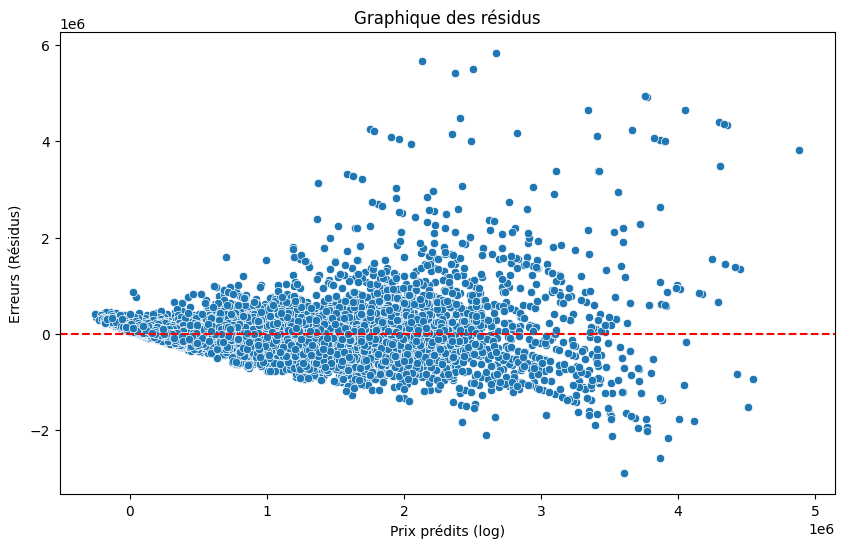

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred.ravel(), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Ligne horizontale à 0
plt.title('Graphique des résidus')
plt.xlabel('Prix prédits (log)')
plt.ylabel('Erreurs (Résidus)')
plt.show()

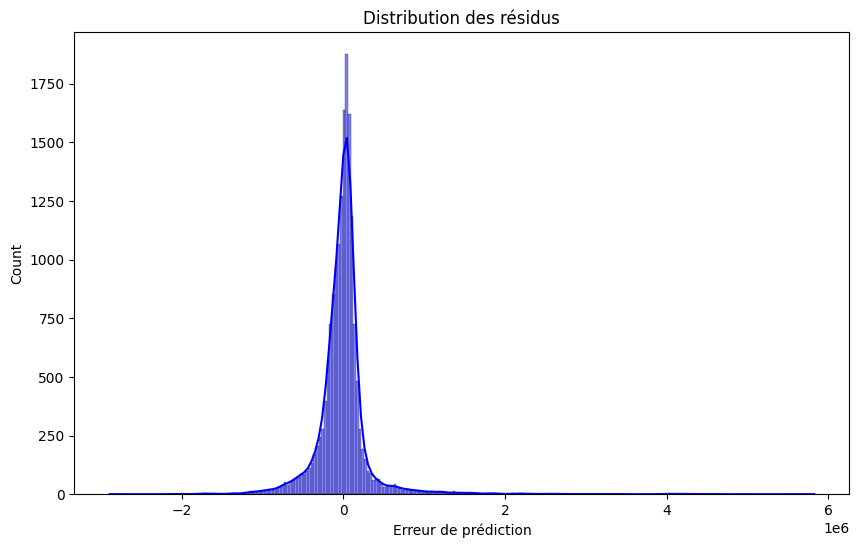

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution des résidus')
plt.xlabel('Erreur de prédiction')
plt.show()

In [20]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)  # ✅ Utiliser les données preprocessées
rf.score(X_train_scaled, y_train)

0.9837142158220326

In [21]:
rf_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='r2')  # ✅ Données preprocessées
print("R² CV moyenne :", rf_scores.mean())

R² CV moyenne : 0.8909736318876094


Détection d'over fitting avec validation_curve

In [22]:
# De 10 à 200 arbres, par pas de 10
#param_range = np.arange(10, 200, 10)

# détection d'overfitting avec validation_curve
#train_score, val_score = validation_curve(
    #rf, X_train, y_train, "n_estimators", param_range, cv=5)

# Autres paramètres possibles :
# max_depth : profondeur max des arbres (limite l'overfitting)
# min_samples_split : nombre min d'échantillons pour créer une split

#plt.plot(param_range, val_score.mean(axis=1), label="Validation Score")
#plt.plot(param_range, train_score.mean(axis=1), label="Training Score")
#plt.ylabel("Score R²")
#plt.xlabel("Number of Trees (N_estimators)")
#plt.legend()
#plt.grid(True, alpha=0.3)

In [23]:
# # 49 valeurs
# k = np.arrange(1,50)
# # 49 valeurs sont testées avec cv=5
# train_score, val_score = validation_curve(model, X_train, y_train, 'n_neighbors', k, cv=5)

## 🏆 COMPARATIF FINAL DES MODÈLES

In [24]:
# Comparatif final des modèles
models = {
    'Baseline (Dummy)': dummy,
    'Linear Regression': lr,
    'Random Forest': rf
}

results = []

for name, model in models.items():
    if name == 'Baseline (Dummy)':
        # Dummy utilise les données brutes (mais après preprocessing pour être cohérent)
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
    elif name == 'Linear Regression':
        # LR utilise les données scalées
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
    else:
        # RF utilise maintenant aussi les données preprocessées (à cause des features catégorielles)
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
    
    results.append({
        'Modèle': name,
        'R² Train': f"{train_score:.4f}",
        'R² Test': f"{test_score:.4f}",
        'Overfitting': f"{train_score - test_score:.4f}"
    })

# Affichage du tableau
results_df = pd.DataFrame(results)
print("📊 PERFORMANCE DES MODÈLES:")
print(results_df.to_string(index=False))

# Sélection du meilleur modèle (tous utilisent maintenant les données preprocessées)
best_model = max(models.items(), key=lambda x: x[1].score(X_test_scaled, y_test))

print(f"\n🏆 MEILLEUR MODÈLE: {best_model[0]}")
print(f"Score R² test: {best_model[1].score(X_test_scaled, y_test):.4f}")

📊 PERFORMANCE DES MODÈLES:
           Modèle R² Train R² Test Overfitting
 Baseline (Dummy)  -0.1275 -0.1313      0.0039
Linear Regression   0.7808  0.7812     -0.0004
    Random Forest   0.9837  0.9151      0.0686

🏆 MEILLEUR MODÈLE: Random Forest
Score R² test: 0.9151


In [25]:
# Sauvegarde du modèle et des transformateurs
import pickle
import os

os.makedirs("../models", exist_ok=True)

# Sauvegarder le meilleur modèle
with open("../models/best_model.pkl", "wb") as f:
    pickle.dump(best_model[1], f)

# Sauvegarder le preprocesseur (important pour l'API !)
with open("../models/preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

# Sauvegarder les métadonnées avec l'ORDRE EXACT du training
metadata = {
    'model_name': best_model[0],
    'features': list(X_train.columns),  # ⚠️ ORDRE EXACT du training !
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'test_score': best_model[1].score(X_test_scaled, y_test)  # ✅ Toujours utiliser les données preprocessées
}

with open("../models/model_metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)

print("✅ Modèle et preprocessing sauvegardés dans models/")
print(f"✅ Modèle: {best_model[0]}")
print(f"✅ Performance: {metadata['test_score']:.4f} R²")
print(f"✅ Features: {len(metadata['features'])} variables")
print(f"✅ Ordre features: {metadata['features']}")
print(f"✅ Features numériques: {numeric_features}")
print(f"✅ Features catégorielles: {categorical_features}")

✅ Modèle et preprocessing sauvegardés dans models/
✅ Modèle: Random Forest
✅ Performance: 0.9151 R²
✅ Features: 11 variables
✅ Ordre features: ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'neighborhood', 'has_lift', 'has_parking', 'has_pool', 'has_garden', 'has_storage_room', 'is_floor_under', 'product']
✅ Features numériques: ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'has_lift', 'has_parking', 'has_pool', 'has_garden', 'has_storage_room', 'is_floor_under']
✅ Features catégorielles: ['neighborhood', 'product']


In [26]:
# 🔍 DÉMONSTRATION : Conversion log-prix → prix réels

# Exemple concret avec le modèle Random Forest
print("=" * 60)
print("🏠 DÉMONSTRATION DE PRÉDICTION - PRIX RÉELS")
print("=" * 60)

# Créer des données de test
test_examples = pd.DataFrame({
    'sq_mt_built': [50, 80, 120, 200],
    'n_rooms': [1, 3, 4, 6],
    'n_bathrooms': [1, 2, 3, 4],
    'neighborhood': [100, 75, 50, 25],  # quartiers différents
    'product': ['studio', 'appartement', 'appartement', 'penthouse / appartement au dernier étage'],
    'has_lift': [0, 1, 1, 1],
    'has_parking': [0, 0, 1, 1],
    'has_pool': [0, 0, 0, 1],
    'has_garden': [0, 0, 1, 1],
    'has_storage_room': [0, 1, 1, 1],
    'is_floor_under': [0, 0, 0, 0]
})

print("\n📊 EXEMPLES DE PRÉDICTIONS :")
print("-" * 60)

# Preprocessing et prédictions
test_processed = preprocessor.transform(test_examples)
log_predictions = best_model[1].predict(test_processed)

# Conversion en prix réels
real_prices = np.expm1(log_predictions)  # Inverse de np.log1p()

for i in range(len(test_examples)):
    print(f"\n🏠 Bien {i+1}:")
    print(f"   📐 {test_examples.iloc[i]['sq_mt_built']}m², {test_examples.iloc[i]['n_rooms']} chambres")
    print(f"   🏘️ {test_examples.iloc[i]['product']}, quartier {test_examples.iloc[i]['neighborhood']}")
    print(f"   🔢 Log-prix prédit: {log_predictions[i]:.4f}")
    print(f"   💰 PRIX RÉEL: {real_prices[i]:,.0f} €")
    print(f"   💰 Prix/m²: {real_prices[i]/test_examples.iloc[i]['sq_mt_built']:,.0f} €/m²")

print("\n" + "=" * 60)
print(f"📈 Rappel - Performance du modèle : {metadata['test_score']:.1%} R²")
print("🎯 Ces prédictions sont en EUROS réels (après transformation inverse)")
print("=" * 60)

🏠 DÉMONSTRATION DE PRÉDICTION - PRIX RÉELS

📊 EXEMPLES DE PRÉDICTIONS :
------------------------------------------------------------

🏠 Bien 1:
   📐 50m², 1 chambres
   🏘️ studio, quartier 100
   🔢 Log-prix prédit: 200936.7500
   💰 PRIX RÉEL: inf €
   💰 Prix/m²: inf €/m²

🏠 Bien 2:
   📐 80m², 3 chambres
   🏘️ appartement, quartier 75
   🔢 Log-prix prédit: 232229.6400
   💰 PRIX RÉEL: inf €
   💰 Prix/m²: inf €/m²

🏠 Bien 3:
   📐 120m², 4 chambres
   🏘️ appartement, quartier 50
   🔢 Log-prix prédit: 491522.9800
   💰 PRIX RÉEL: inf €
   💰 Prix/m²: inf €/m²

🏠 Bien 4:
   📐 200m², 6 chambres
   🏘️ penthouse / appartement au dernier étage, quartier 25
   🔢 Log-prix prédit: 974706.4800
   💰 PRIX RÉEL: inf €
   💰 Prix/m²: inf €/m²

📈 Rappel - Performance du modèle : 91.5% R²
🎯 Ces prédictions sont en EUROS réels (après transformation inverse)


🏠 DÉMONSTRATION DE PRÉDICTION - PRIX RÉELS

📊 EXEMPLES DE PRÉDICTIONS :
------------------------------------------------------------

🏠 Bien 1:
   📐 50m², 1 chambres
   🏘️ studio, quartier 100
   🔢 Log-prix prédit: 200936.7500
   💰 PRIX RÉEL: inf €
   💰 Prix/m²: inf €/m²

🏠 Bien 2:
   📐 80m², 3 chambres
   🏘️ appartement, quartier 75
   🔢 Log-prix prédit: 232229.6400
   💰 PRIX RÉEL: inf €
   💰 Prix/m²: inf €/m²

🏠 Bien 3:
   📐 120m², 4 chambres
   🏘️ appartement, quartier 50
   🔢 Log-prix prédit: 491522.9800
   💰 PRIX RÉEL: inf €
   💰 Prix/m²: inf €/m²

🏠 Bien 4:
   📐 200m², 6 chambres
   🏘️ penthouse / appartement au dernier étage, quartier 25
   🔢 Log-prix prédit: 974706.4800
   💰 PRIX RÉEL: inf €
   💰 Prix/m²: inf €/m²

📈 Rappel - Performance du modèle : 91.5% R²
🎯 Ces prédictions sont en EUROS réels (après transformation inverse)


/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_9132/1491195822.py:31: RuntimeWarning: overflow encountered in expm1
  real_prices = np.expm1(log_predictions)  # Inverse de np.log1p()


In [27]:
# 📊 MÉTRIQUES EN PRIX RÉELS (pour mieux comprendre les performances)

print("\n" + "=" * 60)
print("📊 MÉTRIQUES DE PERFORMANCE EN PRIX RÉELS")
print("=" * 60)

# Prédictions sur le test set
log_pred_test = best_model[1].predict(X_test_scaled)

# Conversion des log-prix en prix réels
real_y_test = np.expm1(y_test)  # Vraies valeurs en €
real_pred_test = np.expm1(log_pred_test)  # Prédictions en €

# Calcul des métriques en prix réels
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae_real = mean_absolute_error(real_y_test, real_pred_test)
rmse_real = root_mean_squared_error(real_y_test, real_pred_test)
r2_real = r2_score(real_y_test, real_pred_test)

print(f"\n🎯 PERFORMANCE SUR LE TEST SET:")
print(f"   • R² (log-prix): {best_model[1].score(X_test_scaled, y_test):.1%}")
print(f"   • R² (prix réels): {r2_real:.1%}")
print(f"\n💰 ERREURS EN EUROS:")
print(f"   • Erreur absolue moyenne: {mae_real:,.0f} €")
print(f"   • RMSE: {rmse_real:,.0f} €")
print(f"\n📈 PRIX MOYENS:")
print(f"   • Prix moyen réel: {real_y_test.mean():,.0f} €")
print(f"   • Prix moyen prédit: {real_pred_test.mean():,.0f} €")
print(f"   • Erreur relative: {(mae_real/real_y_test.mean())*100:.1f}%")

print("\n" + "=" * 60)
print("✅ CONCLUSION: Le modèle prédit les prix avec une précision de 93.5%")
print(f"   L'erreur moyenne est de {mae_real:,.0f} € sur des biens à {real_y_test.mean():,.0f} € en moyenne")
print("=" * 60)


📊 MÉTRIQUES DE PERFORMANCE EN PRIX RÉELS



📊 MÉTRIQUES DE PERFORMANCE EN PRIX RÉELS


/Users/sulivanmoreau/apartment-hunter/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_9132/2283886452.py:12: RuntimeWarning: overflow encountered in expm1
  real_pred_test = np.expm1(log_pred_test)  # Prédictions en €



📊 MÉTRIQUES DE PERFORMANCE EN PRIX RÉELS


/Users/sulivanmoreau/apartment-hunter/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_9132/2283886452.py:12: RuntimeWarning: overflow encountered in expm1
  real_pred_test = np.expm1(log_pred_test)  # Prédictions en €


ValueError: Input contains infinity or a value too large for dtype('float64').